In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("nyc_data.csv")
df = df.rename(columns={"Demand" : "y",
                        "Date" : "ds"})
df.head(5)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [3]:
# Date variable

df.ds = pd.to_datetime(df.ds, format='%m/%d/%Y')
df.ds.head()

0   2015-01-01
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-05
Name: ds, dtype: datetime64[ns]

In [4]:
# Holidays
# Easter

dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({"holiday": "easter",
                       "ds" : dates,
                       "lower_window" : -5,
                       "upper_window" : 2})
easter

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2


In [5]:
# Thanksgiving
dates = pd.to_datetime(df[df.Thanksgiving == 1].ds)
thanksgiving = pd.DataFrame({"holiday": "thanksgiving",
                       "ds" : dates,
                       "lower_window" : -3,
                       "upper_window" : 5})
thanksgiving

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,5
693,thanksgiving,2016-11-24,-3,5
1057,thanksgiving,2017-11-23,-3,5
1421,thanksgiving,2018-11-22,-3,5
1792,thanksgiving,2019-11-28,-3,5
2156,thanksgiving,2020-11-26,-3,5


In [6]:
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,5
693,thanksgiving,2016-11-24,-3,5
1057,thanksgiving,2017-11-23,-3,5
1421,thanksgiving,2018-11-22,-3,5


In [7]:
df = df.drop(columns=["Easter", "Thanksgiving"])

# PROPHET MODEL

In [9]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [10]:
model = Prophet(holidays=holidays,
                seasonality_mode = "multiplicative",
                seasonality_prior_scale = 10,
                holidays_prior_scale = 10,
                changepoint_prior_scale = 0.5)

model.add_regressor("Christmas")
model.add_regressor("Temperature")
model.add_regressor("Marketing")

model.fit(df)


21:13:16 - cmdstanpy - INFO - Chain [1] start processing
21:13:19 - cmdstanpy - INFO - Chain [1] done processing


## Cross-validation

In [11]:
from prophet.diagnostics import cross_validation

In [12]:
df_cv = cross_validation(model,
                         horizon = "31 days",
                         period = "16 days",
                         initial = "2012 days", #df.shape[0] - 180 (6 months)
                         parallel = "processes")

df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,616.919246,557.122996,675.421377,571.069531,2020-07-09
1,2020-07-11,735.492966,669.942829,795.552053,677.106981,2020-07-09
2,2020-07-12,649.586229,586.506191,712.218981,619.572774,2020-07-09
3,2020-07-13,784.349204,722.218237,852.313659,808.932621,2020-07-09
4,2020-07-14,649.748544,585.674004,713.587083,661.791644,2020-07-09


In [13]:
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [14]:
# Performance

performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,2771.214494,52.642326,45.045724,0.063733,0.048442,0.062860,0.829032
1,5 days,3061.927352,55.334685,47.083367,0.067434,0.059769,0.066019,0.741935
2,6 days,3328.783735,57.695613,50.292930,0.070984,0.068063,0.070094,0.700000
3,7 days,2723.982743,52.191788,44.108951,0.063278,0.057707,0.062226,0.767742
4,8 days,2221.065426,47.128181,38.408562,0.053932,0.033162,0.053690,0.796774
5,9 days,1186.296029,34.442648,28.740584,0.039412,0.033126,0.039631,0.922581
6,10 days,1281.310627,35.795400,29.325195,0.040695,0.032196,0.040806,0.903226
7,11 days,1290.961479,35.929952,30.112829,0.042741,0.035380,0.042552,0.929032
8,12 days,2178.385467,46.673177,38.356448,0.055214,0.040870,0.054661,0.774194
9,13 days,2557.093747,50.567714,43.127159,0.061859,0.058046,0.061426,0.674194


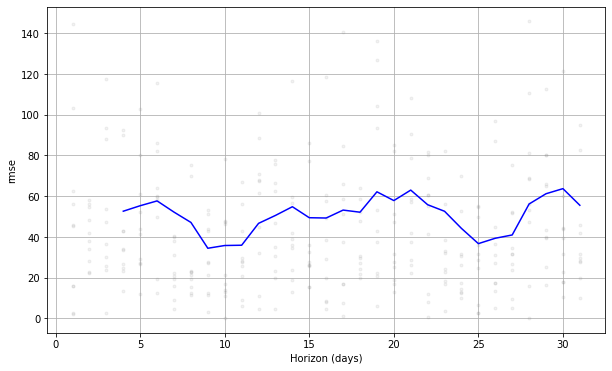

In [16]:
plot_cross_validation_metric(df_cv, metric = "rmse");

# Parameter Tuning

In [17]:
from sklearn.model_selection import ParameterGrid

In [24]:
param_grid = {"seasonality_mode" :["additive", "multiplicative"],
                "seasonality_prior_scale" : [1, 5, 10, 20],
                "holidays_prior_scale" : [5, 10, 20, 25],
                "changepoint_prior_scale" : [0.005, 0.01, 0.05, 0.1]
}

grid = ParameterGrid(param_grid)


In [25]:
list(grid)

[{'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 1},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 1},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_scale': 5,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.005,
  'holidays_prior_s

In [23]:
len(list(grid))

128

In [26]:
rmse = []

for i, params in enumerate(grid, start = 1):

    print(f"Running {i} / {len(list(grid))}")
    
    #Model
    model = Prophet(holidays=holidays,
                    seasonality_mode = params["seasonality_mode"],
                    seasonality_prior_scale = params["seasonality_prior_scale"],
                    holidays_prior_scale = params["holidays_prior_scale"],
                    changepoint_prior_scale = params["changepoint_prior_scale"])
    model.add_regressor("Christmas")
    model.add_regressor("Temperature")
    model.add_regressor("Marketing")

    model.fit(df)

    #CV
    df_cv = cross_validation(model,
                         horizon = "31 days",
                         period = "16 days",
                         initial = "2012 days", #df.shape[0] - 180 (6 months)
                         parallel = "processes")

    epoch_rmse = performance_metrics(df_cv)["rmse"].mean()
    print(f"RMSE for epoch {i} is {epoch_rmse}")
    #Measure Error and Store
    rmse.append(epoch_rmse)

Running 1 / 128


21:47:31 - cmdstanpy - INFO - Chain [1] start processing
21:47:32 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 1 is 53.18518315760396
Running 2 / 128


21:47:50 - cmdstanpy - INFO - Chain [1] start processing
21:47:50 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 2 is 52.879007813534066
Running 3 / 128


21:48:10 - cmdstanpy - INFO - Chain [1] start processing
21:48:11 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 3 is 53.31542253028949
Running 4 / 128


21:48:32 - cmdstanpy - INFO - Chain [1] start processing
21:48:32 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 4 is 52.9833463921711
Running 5 / 128


21:48:49 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 5 is 49.77267660508992
Running 6 / 128


21:49:05 - cmdstanpy - INFO - Chain [1] start processing
21:49:05 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 6 is 49.91301895539415
Running 7 / 128


21:49:21 - cmdstanpy - INFO - Chain [1] start processing
21:49:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 7 is 50.38133985730108
Running 8 / 128


21:49:37 - cmdstanpy - INFO - Chain [1] start processing
21:49:37 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 8 is 50.799200263690636
Running 9 / 128


21:49:53 - cmdstanpy - INFO - Chain [1] start processing
21:49:54 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 9 is 53.54058942121667
Running 10 / 128


21:50:10 - cmdstanpy - INFO - Chain [1] start processing
21:50:10 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 10 is 52.694675220806644
Running 11 / 128


21:50:26 - cmdstanpy - INFO - Chain [1] start processing
21:50:26 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 11 is 52.233644940707464
Running 12 / 128


21:50:45 - cmdstanpy - INFO - Chain [1] start processing
21:50:46 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 12 is 52.650079024605354
Running 13 / 128


21:51:04 - cmdstanpy - INFO - Chain [1] start processing
21:51:05 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 13 is 49.9654027066743
Running 14 / 128


21:51:21 - cmdstanpy - INFO - Chain [1] start processing
21:51:22 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 14 is 49.920043676916286
Running 15 / 128


21:51:38 - cmdstanpy - INFO - Chain [1] start processing
21:51:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 15 is 50.24911154301185
Running 16 / 128


21:51:54 - cmdstanpy - INFO - Chain [1] start processing
21:51:54 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 16 is 50.305127348426346
Running 17 / 128


21:52:10 - cmdstanpy - INFO - Chain [1] start processing
21:52:11 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 17 is 53.23893515483019
Running 18 / 128


21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:27 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 18 is 52.70570563252104
Running 19 / 128


21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 19 is 52.424861099941374
Running 20 / 128


21:52:56 - cmdstanpy - INFO - Chain [1] start processing
21:52:57 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 20 is 52.75270968254707
Running 21 / 128


21:53:13 - cmdstanpy - INFO - Chain [1] start processing
21:53:13 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 21 is 50.15330334991899
Running 22 / 128


21:53:29 - cmdstanpy - INFO - Chain [1] start processing
21:53:30 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 22 is 50.1731920313859
Running 23 / 128


21:53:46 - cmdstanpy - INFO - Chain [1] start processing
21:53:47 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 23 is 49.68611276953048
Running 24 / 128


21:54:03 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 24 is 50.230943588390446
Running 25 / 128


21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 25 is 52.846428024809335
Running 26 / 128


21:54:41 - cmdstanpy - INFO - Chain [1] start processing
21:54:41 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 26 is 53.17062693926693
Running 27 / 128


21:54:57 - cmdstanpy - INFO - Chain [1] start processing
21:54:58 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 27 is 52.81652791937654
Running 28 / 128


21:55:15 - cmdstanpy - INFO - Chain [1] start processing
21:55:15 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 28 is 53.20561614268297
Running 29 / 128


21:55:33 - cmdstanpy - INFO - Chain [1] start processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 29 is 51.016449405476386
Running 30 / 128


21:55:50 - cmdstanpy - INFO - Chain [1] start processing
21:55:50 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 30 is 50.1586540156972
Running 31 / 128


21:56:08 - cmdstanpy - INFO - Chain [1] start processing
21:56:09 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 31 is 50.04510147839981
Running 32 / 128


21:56:25 - cmdstanpy - INFO - Chain [1] start processing
21:56:26 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 32 is 49.81218706781815
Running 33 / 128


21:56:45 - cmdstanpy - INFO - Chain [1] start processing
21:56:45 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 33 is 48.36698747299489
Running 34 / 128


21:57:01 - cmdstanpy - INFO - Chain [1] start processing
21:57:02 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 34 is 47.87161449453226
Running 35 / 128


21:57:20 - cmdstanpy - INFO - Chain [1] start processing
21:57:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 35 is 48.87176184925083
Running 36 / 128


21:57:37 - cmdstanpy - INFO - Chain [1] start processing
21:57:38 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 36 is 48.42749722289296
Running 37 / 128


21:57:57 - cmdstanpy - INFO - Chain [1] start processing
21:57:57 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 37 is 49.03229493075894
Running 38 / 128


21:58:13 - cmdstanpy - INFO - Chain [1] start processing
21:58:13 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 38 is 49.222530815046824
Running 39 / 128


21:58:32 - cmdstanpy - INFO - Chain [1] start processing
21:58:32 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 39 is 49.229139496468584
Running 40 / 128


21:58:49 - cmdstanpy - INFO - Chain [1] start processing
21:58:50 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 40 is 49.128357706886604
Running 41 / 128


21:59:09 - cmdstanpy - INFO - Chain [1] start processing
21:59:09 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 41 is 48.351337305396044
Running 42 / 128


21:59:28 - cmdstanpy - INFO - Chain [1] start processing
21:59:29 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 42 is 48.20016382117325
Running 43 / 128


21:59:45 - cmdstanpy - INFO - Chain [1] start processing
21:59:45 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 43 is 48.31966540390166
Running 44 / 128


21:59:59 - cmdstanpy - INFO - Chain [1] start processing
21:59:59 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 44 is 48.25625968570298
Running 45 / 128


22:00:14 - cmdstanpy - INFO - Chain [1] start processing
22:00:15 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 45 is 49.24545103790732
Running 46 / 128


22:00:30 - cmdstanpy - INFO - Chain [1] start processing
22:00:30 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 46 is 49.105057322621064
Running 47 / 128


22:00:46 - cmdstanpy - INFO - Chain [1] start processing
22:00:46 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 47 is 49.22858642453087
Running 48 / 128


22:00:59 - cmdstanpy - INFO - Chain [1] start processing
22:01:00 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 48 is 49.284183018956604
Running 49 / 128


22:01:15 - cmdstanpy - INFO - Chain [1] start processing
22:01:16 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 49 is 48.588767810697156
Running 50 / 128


22:01:30 - cmdstanpy - INFO - Chain [1] start processing
22:01:31 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 50 is 48.267641799741774
Running 51 / 128


22:01:46 - cmdstanpy - INFO - Chain [1] start processing
22:01:46 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 51 is 48.37758131383588
Running 52 / 128


22:01:56 - cmdstanpy - INFO - Chain [1] start processing
22:01:56 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 52 is 48.419223503170016
Running 53 / 128


22:02:12 - cmdstanpy - INFO - Chain [1] start processing
22:02:12 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 53 is 49.16691452339314
Running 54 / 128


22:02:27 - cmdstanpy - INFO - Chain [1] start processing
22:02:27 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 54 is 49.183127509550175
Running 55 / 128


22:02:42 - cmdstanpy - INFO - Chain [1] start processing
22:02:43 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 55 is 49.08250436215544
Running 56 / 128


22:02:59 - cmdstanpy - INFO - Chain [1] start processing
22:03:00 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 56 is 48.86422845389096
Running 57 / 128


22:03:12 - cmdstanpy - INFO - Chain [1] start processing
22:03:13 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 57 is 48.362882409169615
Running 58 / 128


22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 58 is 48.37545157307342
Running 59 / 128


22:03:44 - cmdstanpy - INFO - Chain [1] start processing
22:03:44 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 59 is 48.276362326213466
Running 60 / 128


22:03:54 - cmdstanpy - INFO - Chain [1] start processing
22:03:55 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 60 is 48.829043757161976
Running 61 / 128


22:04:09 - cmdstanpy - INFO - Chain [1] start processing
22:04:09 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 61 is 49.03962582046755
Running 62 / 128


22:04:26 - cmdstanpy - INFO - Chain [1] start processing
22:04:27 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 62 is 49.4215569636979
Running 63 / 128


22:04:42 - cmdstanpy - INFO - Chain [1] start processing
22:04:42 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 63 is 49.55030373406989
Running 64 / 128


22:05:01 - cmdstanpy - INFO - Chain [1] start processing
22:05:01 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 64 is 49.168146255874426
Running 65 / 128


22:05:17 - cmdstanpy - INFO - Chain [1] start processing
22:05:18 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 65 is 49.910960283182796
Running 66 / 128


22:05:41 - cmdstanpy - INFO - Chain [1] start processing
22:05:43 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 66 is 49.901114739164846
Running 67 / 128


22:06:03 - cmdstanpy - INFO - Chain [1] start processing
22:06:04 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 67 is 50.07432964488339
Running 68 / 128


22:06:24 - cmdstanpy - INFO - Chain [1] start processing
22:06:25 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 68 is 50.029867365661666
Running 69 / 128


22:06:46 - cmdstanpy - INFO - Chain [1] start processing
22:06:47 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 69 is 53.661950632390884
Running 70 / 128


22:07:06 - cmdstanpy - INFO - Chain [1] start processing
22:07:06 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 70 is 53.73929694580984
Running 71 / 128


22:07:24 - cmdstanpy - INFO - Chain [1] start processing
22:07:25 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 71 is 53.717080249352314
Running 72 / 128


22:07:44 - cmdstanpy - INFO - Chain [1] start processing
22:07:45 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 72 is 53.78734444751383
Running 73 / 128


22:08:04 - cmdstanpy - INFO - Chain [1] start processing
22:08:05 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 73 is 49.93084964419454
Running 74 / 128


22:08:23 - cmdstanpy - INFO - Chain [1] start processing
22:08:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 74 is 50.0910102987554
Running 75 / 128


22:08:42 - cmdstanpy - INFO - Chain [1] start processing
22:08:45 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 75 is 50.17482778683199
Running 76 / 128


22:09:04 - cmdstanpy - INFO - Chain [1] start processing
22:09:05 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 76 is 49.9556025872118
Running 77 / 128


22:09:25 - cmdstanpy - INFO - Chain [1] start processing
22:09:25 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 77 is 54.01962330006175
Running 78 / 128


22:09:46 - cmdstanpy - INFO - Chain [1] start processing
22:09:47 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 78 is 53.75749881013736
Running 79 / 128


22:10:02 - cmdstanpy - INFO - Chain [1] start processing
22:10:03 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 79 is 53.87900814021837
Running 80 / 128


22:10:23 - cmdstanpy - INFO - Chain [1] start processing
22:10:24 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 80 is 53.79821543412101
Running 81 / 128


22:10:42 - cmdstanpy - INFO - Chain [1] start processing
22:10:43 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 81 is 49.80674045174063
Running 82 / 128


22:11:01 - cmdstanpy - INFO - Chain [1] start processing
22:11:03 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 82 is 50.04920528211538
Running 83 / 128


22:11:24 - cmdstanpy - INFO - Chain [1] start processing
22:11:25 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 83 is 49.76867957958241
Running 84 / 128


22:11:46 - cmdstanpy - INFO - Chain [1] start processing
22:11:47 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 84 is 50.079884433261256
Running 85 / 128


22:12:08 - cmdstanpy - INFO - Chain [1] start processing
22:12:09 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 85 is 53.860167030284565
Running 86 / 128


22:12:31 - cmdstanpy - INFO - Chain [1] start processing
22:12:32 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 86 is 53.5857485600058
Running 87 / 128


22:12:51 - cmdstanpy - INFO - Chain [1] start processing
22:12:52 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 87 is 53.807023424886246
Running 88 / 128


22:13:13 - cmdstanpy - INFO - Chain [1] start processing
22:13:14 - cmdstanpy - INFO - Chain [1] done processing


RMSE for epoch 88 is 53.7787023802389
Running 89 / 128


22:13:35 - cmdstanpy - INFO - Chain [1] start processing
22:13:36 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 